# Pressure anomalies/ cyclogenesis

In [1]:
import os

import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import numpy as np
import pandas as pd

import pyproj
from datetime import datetime, timedelta
from oceanpy import Contour, haversine

import matplotlib.pyplot as plt
import cmocean as cmo
import string

In [2]:
figsdir = os.path.join(os.sep, 'g', 'data', 'jk72', 'jm6603', 'checkouts', 'phd-figs', 'manuscripts', '02_manuscript')
outdir = os.path.join(os.sep, 'g', 'data', 'jk72', 'jm6603', 'checkouts', 'phd', 'src', 'cosima', '02_manuscript', 'output')

In [3]:
savefig = False

fs_small = 22
fs_large = 24

plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('axes', labelsize=fs_large)
plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm', 'font.size': fs_small})
plt.rc('text.latex', preamble=r'\usepackage{xfrac}\usepackage{amsmath}\usepackage{amsfonts}\usepackage{amssymb}')

In [4]:
def pmean(p, time_sel, dt=15):
    
    if type(time_sel.values) is np.datetime64:
        time_sel = pd.to_datetime(time_sel.values)
    elif type(time_sel) is str:
        time_sel = datetime.strptime(time_sel, '%Y-%m-%d')
#     if type(time_sel) is datetime:
#         pass
#     if type(time_sel) is pd.Timestamp:
#         pass
    dt = timedelta(days = dt)
    time_sel = slice(time_sel - dt, time_sel + dt)
    
    return p.sel(time=time_sel).mean('time')

def coord_cross(along_section, coord_sel):
    idx = np.argmin([haversine([ln, coord_sel[0]], [lt, coord_sel[1]])[0]
                     for ln, lt in zip(along_section.xt_ocean, along_section.yt_ocean)])
    return along_section['along-section'][idx]

## Load and select data

In [5]:
client = Client(threads_per_worker=1, memory_limit=0)
client.amm.start()

In [6]:
lon_lim = slice(-224, -212.5)
lat_lim = slice(-53.5, -47.5)

# Load hydrography data
file_name = os.path.join(outdir, 'hydro.nc')
ds = xr.open_dataset(file_name)
ds_sel = ds.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)

hydro = ds_sel.assign_coords(
    xt_ocean=((ds_sel.xt_ocean + 180) % 360) - 180,
    xu_ocean=((ds_sel.xu_ocean + 180) % 360) - 180,
)

# Load velocity data
file_name = os.path.join(outdir, 'vel.nc')
ds_vel = xr.open_dataset(file_name).sel(
    xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
vel = ds_vel.assign_coords(
    xt_ocean=((ds_vel.xt_ocean + 180) % 360) - 180,
    xu_ocean=((ds_vel.xu_ocean + 180) % 360) - 180,
)
vel['V'] = ((vel.u**2 + vel.v**2)**(1/2)).compute()

# depth and time of interest
p_int = 2500
flex_period = slice('1997-04-10', '1997-04-25')
# interesting time development cyclone 1997-03-15 until 1997-05-25
meander_period = slice('1997-02-15', '1997-05-31')

In [7]:
hydro

<xarray.Dataset>
Dimensions:    (xt_ocean: 115, yt_ocean: 95, st_ocean: 75, time: 181,
                xu_ocean: 115, yu_ocean: 94)
Coordinates:
  * xt_ocean   (xt_ocean) float64 136.1 136.2 136.3 136.4 ... 147.3 147.4 147.5
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time       (time) datetime64[ns] 1997-01-01T12:00:00 ... 1997-06-30T12:00:00
  * xu_ocean   (xu_ocean) float64 136.0 136.1 136.2 136.3 ... 147.2 147.3 147.4
  * yu_ocean   (yu_ocean) float64 -53.46 -53.4 -53.34 ... -47.69 -47.62 -47.56
Data variables: (12/13)
    dxt        (yt_ocean, xt_ocean) float32 ...
    dyt        (yt_ocean, xt_ocean) float32 ...
    dst        (st_ocean, yt_ocean, xt_ocean) float32 ...
    dxu        (yu_ocean, xu_ocean) float32 ...
    dyu        (yu_ocean, xu_ocean) float32 ...
    area_t     (yt_ocean, xt_ocean) float32 ...
    ...         ...
    ht         (yt_ocean, xt_ocean) float32 ...
    sea_level  (time, yt_ocean, xt_ocean) float32 ...
    SA         (time, st_ocean, yt_ocean, xt_ocean) float64 ...
    CT         (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    deltaD     (time, st_ocean, yt_ocean, xt_ocean) float64 ...
    pressure   (time, st_ocean, yt_ocean, xt_ocean) float64 ...
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       /g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-06-09
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Source code: https://github.com/COSIMA/access-om2 License:...

## Time evolution

In [8]:
days = 7
sl_wkmean = hydro.sea_level.resample(time='%sD'%days).mean()

Text(0, 0.5, 'sea level (m)')

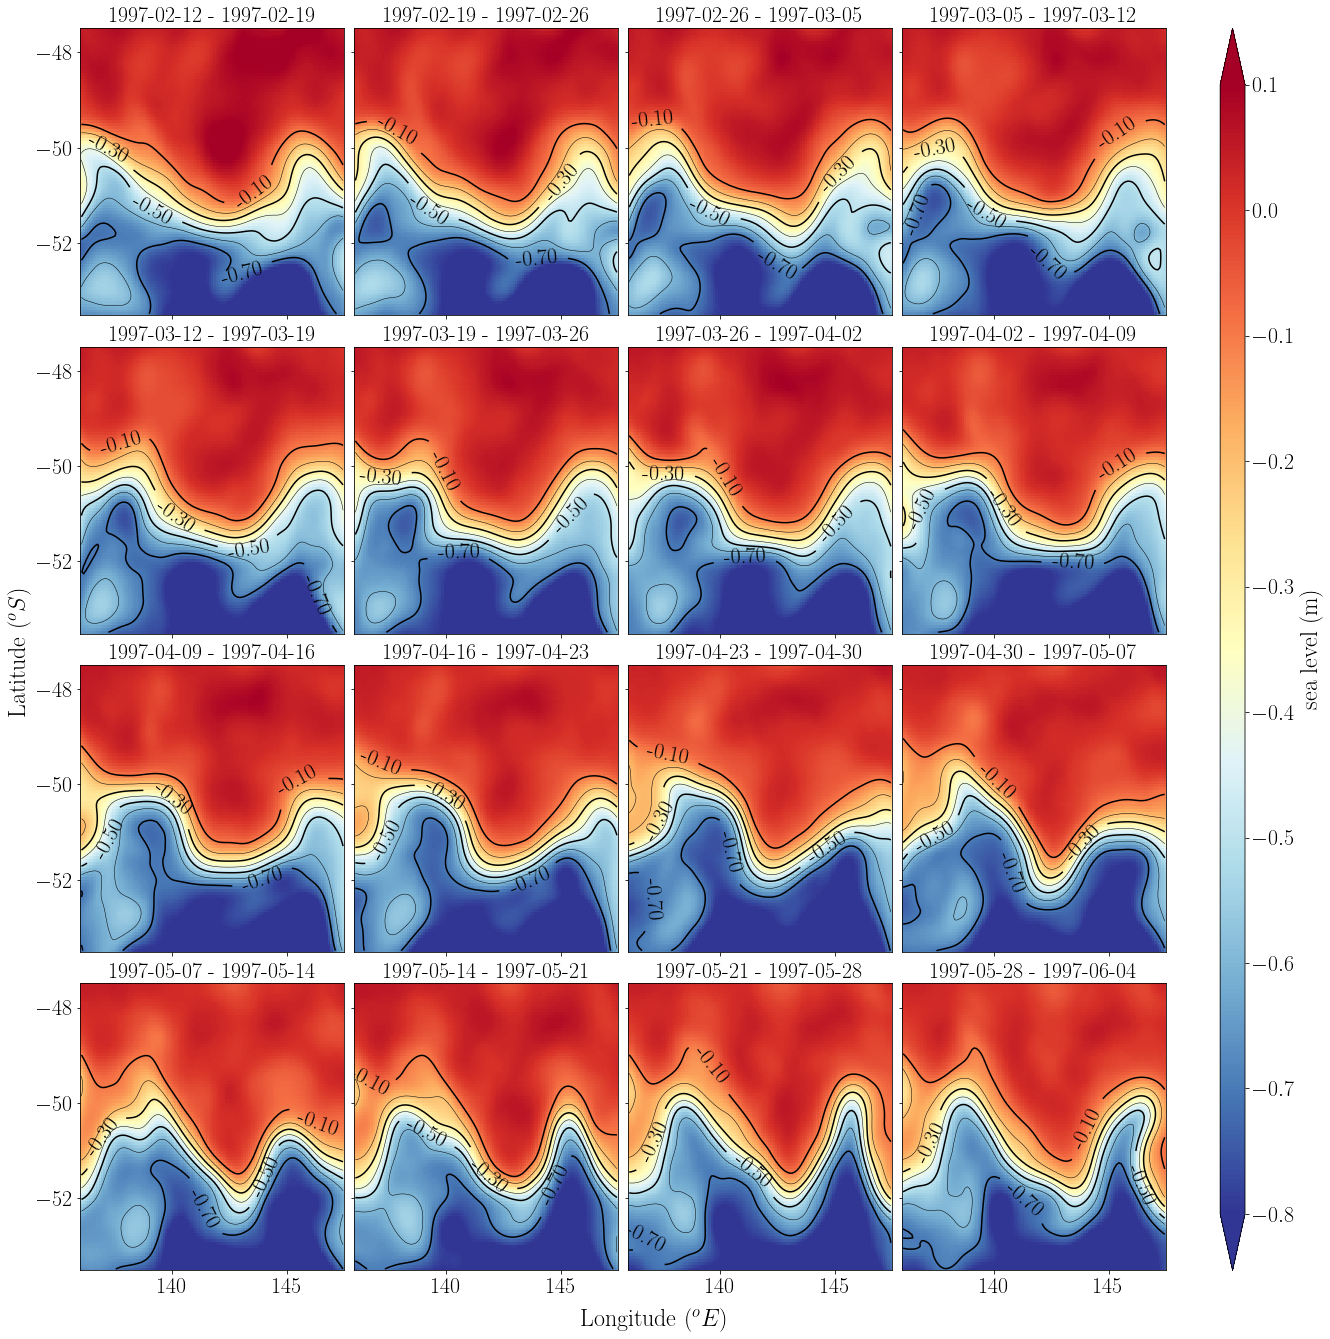

In [9]:
sl_contours = np.linspace(-0.7, -0.1, 7)

nrows, ncols = 4, 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18), 
                         sharex=True, sharey=True, constrained_layout=True)
for i, t in enumerate(sl_wkmean.time[6:-4]):
    r, c = i // ncols, i % ncols    
    
    pcol = sl_wkmean.sel(time=t).plot.pcolormesh(
        ax=ax[r, c], vmin=-0.8, vmax=0.1, cmap=plt.cm.RdYlBu_r, add_colorbar=False)
#     pcol = (sst_wkmean - 273).sel(time=t).plot.pcolormesh(
#         ax=ax[r, c], vmin=4, vmax=11, cmap=cmo.cm.thermal, add_colorbar=False)
    cont = sl_wkmean.sel(time=t).plot.contour(
        ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=0.5, colors='k')
    
    for ib, b in enumerate(sl_contours):
        if b in sl_contours[0::2]:
            zc = cont.collections[ib]
            plt.setp(zc, linewidth=1.5)
    ax[r, c].clabel(cont, sl_contours[0::2], inline=1, fontsize=fs_small, fmt='%.2f')
    
    ax[r, c].set_ylabel('')
    ax[r, c].set_xlabel('')
#     ts = pd.to_datetime(str(sl_wkmean.time[i].data))
    t_start = pd.to_datetime(str(t.data)).strftime('%Y-%m-%d')
    t_end = (pd.to_datetime(str(t.data))+timedelta(days = days)).strftime('%Y-%m-%d')

    ax[r, c].set_title('%s - %s' %(t_start, t_end), fontsize=fs_small)

        
fig.text(0.48, -0.02, r'Longitude ($^oE$)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Latitude ($^oS$)', va='center', rotation='vertical', fontsize=fs_large)

cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel('sea level (m)', fontsize=fs_large)

## Define core of the front

In [10]:
sl_flex = hydro.sea_level.sel(time=flex_period, yt_ocean=slice(-52.5, -49))

# calculate sea level gradient over flexed meander period
sl_dx = sl_flex.differentiate('xt_ocean')
sl_dy = sl_flex.differentiate('yt_ocean')
sl_grad = sl_dx + sl_dy
sl_grad.name = 'sea_level_gradient'

sl_flex = xr.merge([sl_flex, sl_grad])

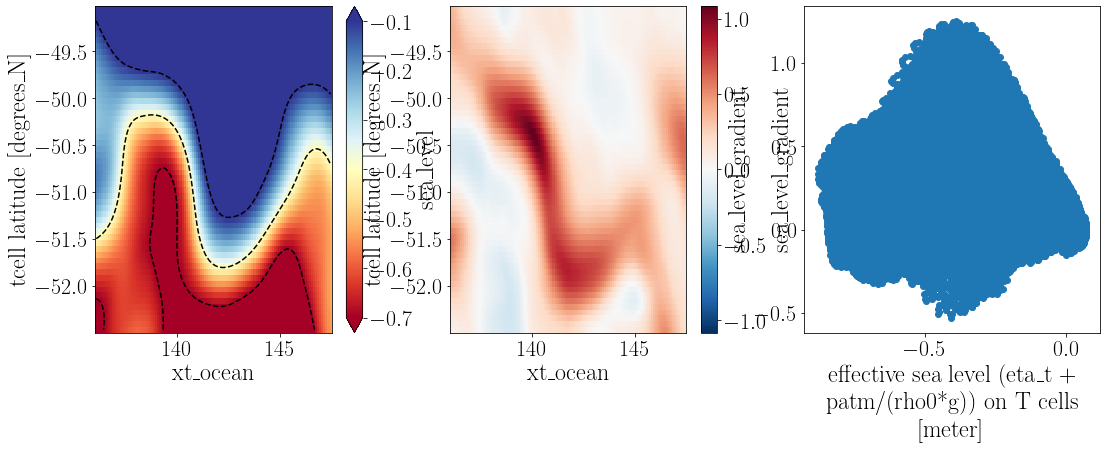

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))
sl_flex.sea_level.mean('time').plot(ax=ax[0], vmin=-0.7, vmax=-0.1, cmap=plt.cm.RdYlBu)
sl_flex.sea_level.mean('time').plot.contour(ax=ax[0], levels=[-0.7, -0.4, -0.1], colors='k')
sl_flex.sea_level_gradient.mean('time').plot(ax=ax[1])
sl_flex.plot.scatter(ax=ax[2], x='sea_level', y='sea_level_gradient')


In [12]:
sl_scat = sl_flex.where((sl_flex.sea_level > -0.7) & (sl_flex.sea_level < -0.1)).where(
    sl_flex.sea_level_gradient > 0.25).stack(t=('time','xt_ocean', 'yt_ocean'))

In [13]:
x = np.ma.masked_invalid(sl_scat.sea_level.values.flatten())
y = np.ma.masked_invalid(sl_scat.sea_level_gradient.values.flatten())
pf = np.polyfit(x[~x.mask], y[~x.mask], 2)
f = np.poly1d(pf)
xpf = np.linspace(-0.7, -0.1, 61)
ypf = f(xpf)
dydx = np.gradient(ypf) / np.gradient(xpf)
idx = np.argmin(abs(0 - dydx))

In [14]:
core_contour = np.round(xpf[idx], 2)
sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]
core_contour

-0.4

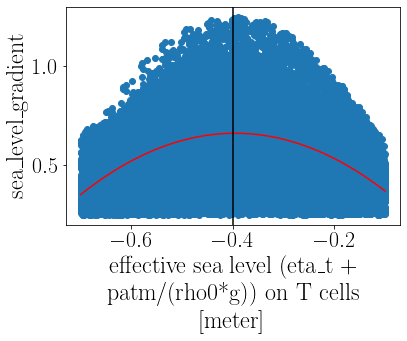

In [15]:
sl_scat.plot.scatter(x='sea_level', y='sea_level_gradient')
plt.plot(xpf, ypf, 'r')
plt.axvline(core_contour, color='k')

## Development of deep pressure anomalies (cyclogenesis)

In [16]:
days=5
base_period = slice('1997-01-01', '1997-06-30')

print('time steps: ', len(hydro.pressure.sel(time=meander_period).time), 'pressure level: ', p_int)
print('time steps: ', len(hydro.pressure.sel(time=base_period).time))
print('time steps: ', len(hydro.pressure.sel(time=flex_period).time))

p_baseline = hydro.pressure.sel(time=base_period).mean('time').sel(st_ocean=p_int, method='nearest')
p_baseline2 = hydro.pressure.sel(time=meander_period).mean('time').sel(st_ocean=p_int, method='nearest')
p_baseline3 = hydro.pressure.sel(time=slice('1997-01-15', '1997-02-15')).mean('time').sel(st_ocean=p_int, method='nearest')

p_anomalous = hydro.pressure.sel(time=meander_period) - p_baseline
p_anom_5dm = p_anomalous.resample(time='%sD'%days).mean()

time steps:  106 pressure level:  2500
time steps:  181
time steps:  16


## Baseline period

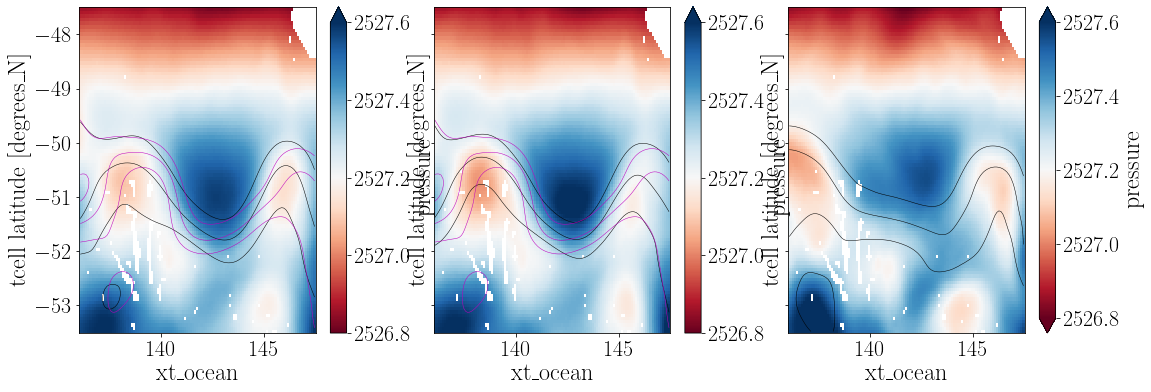

In [17]:
cmap='RdBu'
vmin, vmax = 2526.8, 2527.6
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(18,6))

p_baseline.plot(ax=ax[0],vmin=vmin, vmax=vmax, cmap=cmap)
hydro.sea_level.sel(time=base_period).mean('time').plot.contour(
    ax=ax[0], levels=sl_contours, linestyles='solid', linewidths=0.5, colors='k')
hydro.sea_level.sel(time=flex_period).mean('time').plot.contour(
    ax=ax[0], levels=sl_contours, linestyles='solid', linewidths=0.5, colors='m')

p_baseline2.plot(ax=ax[1],vmin=vmin, vmax=vmax, cmap=cmap)
hydro.sea_level.sel(time=meander_period).mean('time').plot.contour(
    ax=ax[1], levels=sl_contours, linestyles='solid', linewidths=0.5, colors='k')
hydro.sea_level.sel(time=flex_period).mean('time').plot.contour(
    ax=ax[1], levels=sl_contours, linestyles='solid', linewidths=0.5, colors='m')

p_baseline3.plot(ax=ax[2],vmin=vmin, vmax=vmax, cmap=cmap)
hydro.sea_level.sel(time=slice('1997-01-15', '1997-02-15')).mean('time').plot.contour(
    ax=ax[2], levels=sl_contours, linestyles='solid', linewidths=0.5, colors='k')

In [18]:
p_anom_5dm.time[5:-1].time

<xarray.DataArray 'time' (time: 16)>
array(['1997-03-12T00:00:00.000000000', '1997-03-17T00:00:00.000000000',
       '1997-03-22T00:00:00.000000000', '1997-03-27T00:00:00.000000000',
       '1997-04-01T00:00:00.000000000', '1997-04-06T00:00:00.000000000',
       '1997-04-11T00:00:00.000000000', '1997-04-16T00:00:00.000000000',
       '1997-04-21T00:00:00.000000000', '1997-04-26T00:00:00.000000000',
       '1997-05-01T00:00:00.000000000', '1997-05-06T00:00:00.000000000',
       '1997-05-11T00:00:00.000000000', '1997-05-16T00:00:00.000000000',
       '1997-05-21T00:00:00.000000000', '1997-05-26T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1997-03-12 1997-03-17 ... 1997-05-26

In [19]:
V_threshold = 0.07 #m/s
vel_5dm = vel.sel(time=slice('1997-03-12', None)).resample(time='%sD'%days).mean()

hydro_5dm = hydro.sel(time=slice('1997-03-12', None)).resample(time='%sD'%days).mean()

### Find storm tracks

In [20]:
storm_tracks = {
    'low1': {'start': datetime.strptime('1997-04-01', '%Y-%m-%d'), 'end': datetime.strptime('1997-05-10', '%Y-%m-%d'), 'lon_start': 139,  'lon_end': 142, 'lon': [], 'lat': [], 'time': []},
    'low2': {'start': datetime.strptime('1997-03-27', '%Y-%m-%d'), 'end': datetime.strptime('1997-06-01', '%Y-%m-%d'), 'lon_start': 141.7,  'lon_end': 146.3, 'lon': [], 'lat': [], 'time': [] },
    'high1': {'start': datetime.strptime('1997-04-16', '%Y-%m-%d'), 'end': datetime.strptime('1997-05-10', '%Y-%m-%d'), 'lon_start': 136,  'lon_end': 140, 'lon': [], 'lat': [], 'time': [] },
    'high2': {'start': datetime.strptime('1997-04-26', '%Y-%m-%d'), 'end': datetime.strptime('1997-05-20', '%Y-%m-%d'), 'lon_start': 140,  'lon_end': 144, 'lon': [], 'lat': [], 'time': [] },
}
for i, t in enumerate(p_anom_5dm.time[5:-1]):#p.sel(time=flex_period).time):
    for track in storm_tracks:
        if storm_tracks[track]['start'] < pd.to_datetime(t.values) <= storm_tracks[track]['end']: 
            p_t = p_anom_5dm.sel(time=t, xt_ocean=slice(storm_tracks[track]['lon_start'], storm_tracks[track]['lon_end'])).sel(st_ocean=p_int, method='nearest')
            if track[:3] == 'low':
                pextreme = p_t.where(p_t==p_t.min(), drop=True)
            elif track[:4] == 'high':
                pextreme = p_t.where(p_t==p_t.max(), drop=True)
            storm_tracks[track]['lon'].append(pextreme.xt_ocean.values[0]) 
            storm_tracks[track]['lat'].append(pextreme.yt_ocean.values[0]) 
            storm_tracks[track]['time'].append(pextreme.time.values)


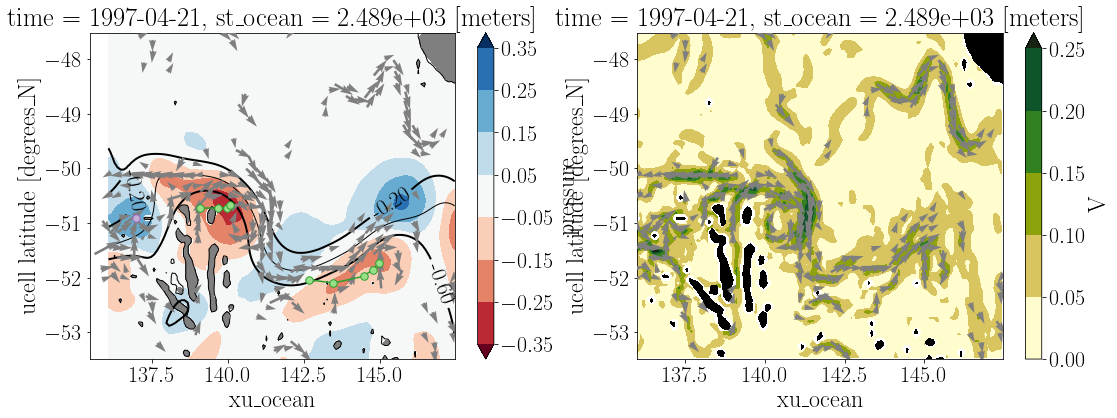

In [21]:
slc = slice(None, None, 3)
cmap = plt.cm.RdBu #cmo.cm.balance
vmin, vmax = -0.35, 0.35
bounds = np.linspace(vmin, vmax, 8)

fig, ax = plt.subplots(ncols=2, figsize=(18,6))
t = p_anom_5dm.time[-9]

# plot topography
hydro.ht.plot.contourf(ax=ax[0], levels=[0, 2500, 5000], colors=['tab:gray', (1, 1, 1, 0)], add_colorbar=False)
hydro.ht.plot.contour(ax=ax[0], levels=[2500], colors='k', linewidths=1)
hydro.ht.plot.contourf(ax=ax[1], levels=[0, 2500, 5000], colors=['k', (1, 1, 1, 0)], add_colorbar=False)

# pressure anomalies
pcol = p_anom_5dm.sel(time=t).sel(st_ocean=p_int, method='nearest').plot.contourf(
    ax=ax[0], levels=bounds, cmap=cmap, extend='both', add_colorbar=True)

# sea level contours
cont = hydro_5dm.sea_level.sel(time=t).plot.contour(
    ax=ax[0], levels=sl_contours, linestyles='solid', linewidths=1, colors='k')
for ib, b in enumerate(sl_contours):
    if b in sl_contours[0::2]:
        zc = cont.collections[ib]
        plt.setp(zc, linewidth=2)
ax[0].clabel(cont, sl_contours[0::2], inline=1, fontsize=fs_small, fmt='%.2f')

# horizontal velocities at 2500dbar
vel_t = vel_5dm.sel(time=t).sel(st_ocean=p_int, method='nearest')
quiv = vel_t.where(vel_t.V >= V_threshold).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[0], x='xu_ocean', y='yu_ocean', u='u', v='v', color='tab:gray',
    units='inches', pivot='mid', scale=.5, width=2e-3*fig.get_size_inches()[0], add_guide=False, zorder=3)
qk = plt.quiverkey(quiv, 0.85, 1.0, .5, r'$0.5\:\mathrm{ms}^{-1}$', labelpos='E', coordinates='figure',
               fontproperties={'size': fs_large})

conf = vel_t.V.plot.contourf(ax=ax[1], levels=np.linspace(0,0.25,6), cmap=cmo.cm.speed)
quiv = vel_t.where(vel_t.V >= V_threshold).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[1], x='xu_ocean', y='yu_ocean', u='u', v='v', color='tab:gray',
    units='inches', pivot='mid', scale=.5, width=2e-3*fig.get_size_inches()[0], add_guide=False, zorder=3)
qk = plt.quiverkey(quiv, 0.85, 1.0, .5, r'$0.5\:\mathrm{ms}^{-1}$', labelpos='E', coordinates='figure',
               fontproperties={'size': fs_large})

# plot storm tracks
# low pressures
if t in storm_tracks['low1']['time']:
    idt = np.where(t.values >= storm_tracks['low1']['time'])[0]
    ax[0].plot(np.array(storm_tracks['low1']['lon'])[idt], np.array(storm_tracks['low1']['lat'])[idt], 
                  '.-', zorder=4, color=plt.cm.get_cmap('tab20').colors[4], markersize=15, markerfacecolor=plt.cm.get_cmap('tab20').colors[5])
if t in storm_tracks['low2']['time']:
    idt = np.where(t.values >= storm_tracks['low2']['time'])[0]
    ax[0].plot(np.array(storm_tracks['low2']['lon'])[idt], np.array(storm_tracks['low2']['lat'])[idt], 
                  '.-', zorder=4, color=plt.cm.get_cmap('tab20').colors[4], markersize=15, markerfacecolor=plt.cm.get_cmap('tab20').colors[5])
# high pressures
if t in storm_tracks['high1']['time']:
    idt = np.where(t.values >= storm_tracks['high1']['time'])[0]
    ax[0].plot(np.array(storm_tracks['high1']['lon'])[idt], np.array(storm_tracks['high1']['lat'])[idt], 
                  '.-', zorder=4, color=plt.cm.get_cmap('tab20').colors[8], markersize=15, markerfacecolor=plt.cm.get_cmap('tab20').colors[9])
if t in storm_tracks['high2']['time']:
    idt = np.where(t.values >= storm_tracks['high2']['time'])[0]
    ax[0].plot(np.array(storm_tracks['high2']['lon'])[idt], np.array(storm_tracks['high2']['lat'])[idt], 
                  '.-', zorder=4, color=plt.cm.get_cmap('tab20').colors[8], markersize=15, markerfacecolor=plt.cm.get_cmap('tab20').colors[9])

Text(0, 0.5, 'Pressure anomaly (dbar)')

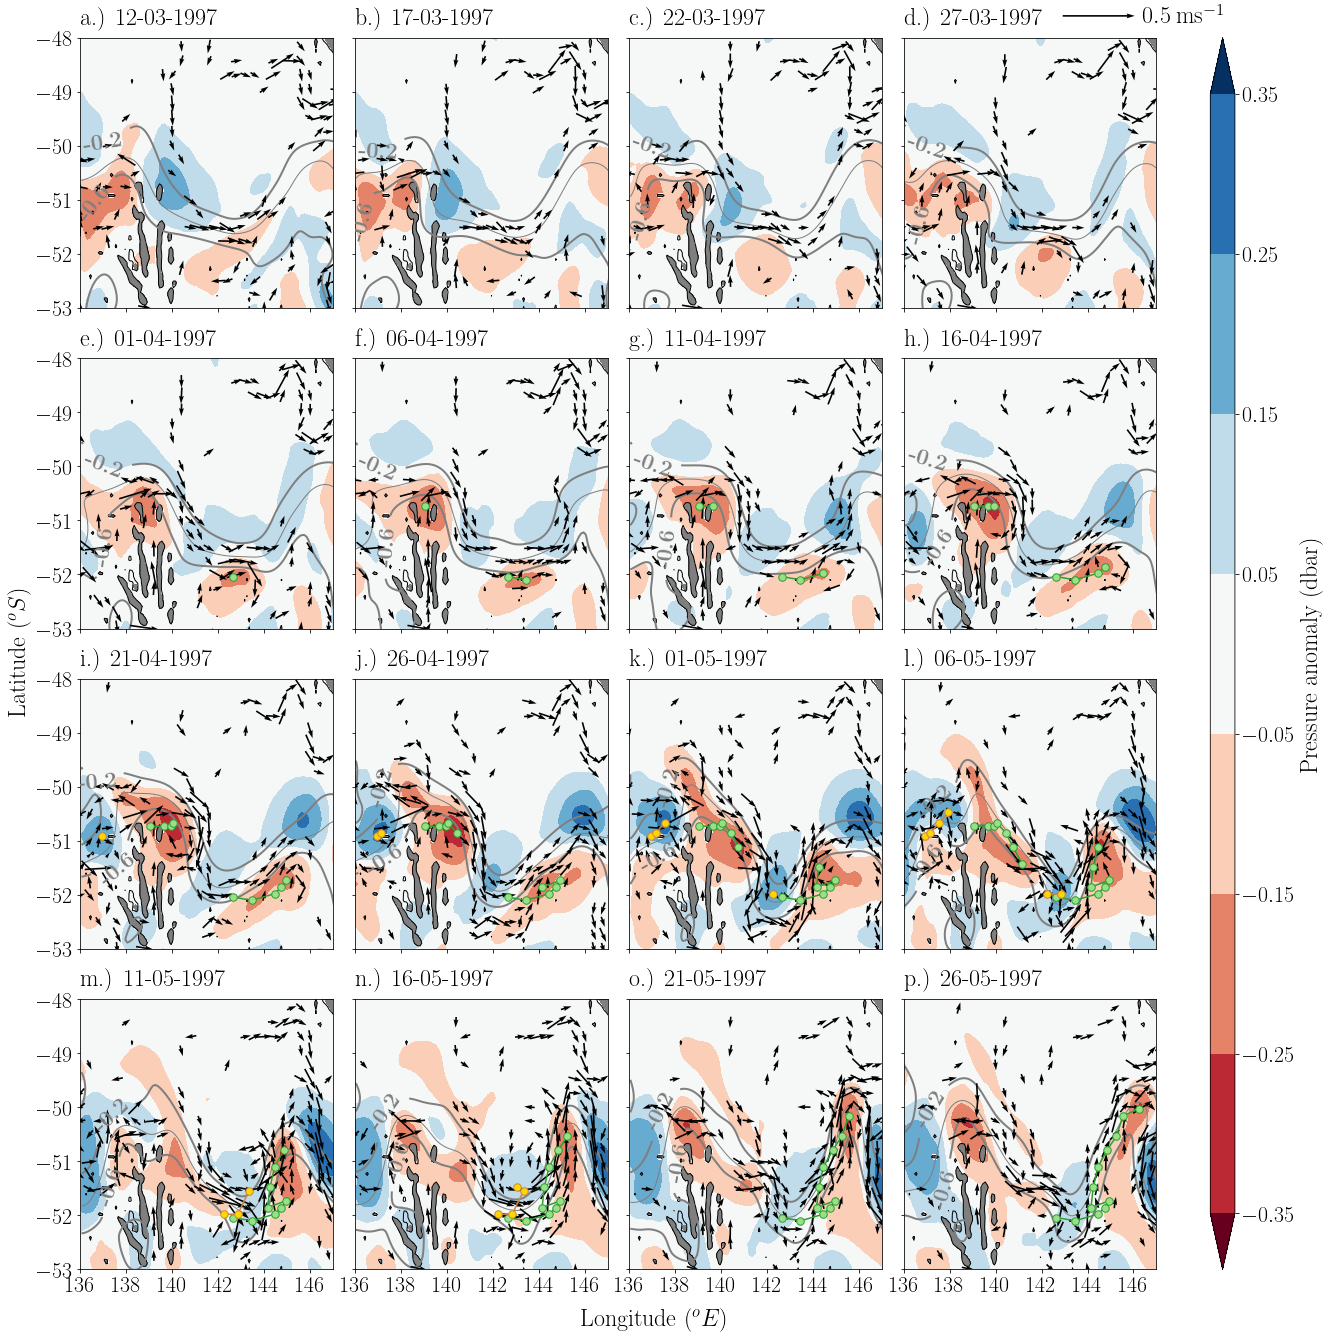

In [22]:
slc = slice(None, None, 4)
cmap = plt.cm.RdBu #plt.cm.RdGy #cmo.cm.balance
vmin, vmax = -0.35, 0.35
bounds = np.linspace(vmin, vmax, 8)

nrows, ncols = 4, 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18), 
                         sharex=True, sharey=True, constrained_layout=True)

for i, t in enumerate(p_anom_5dm.time[5:-1]):#p.sel(time=flex_period).time):
    r, c = i // ncols, i % ncols    

    # plot topography
    hydro.ht.plot.contourf(ax=ax[r, c], levels=[0, 2500, 5000], colors=['tab:gray', (1, 1, 1, 0)], add_colorbar=False)
    hydro.ht.plot.contour(ax=ax[r, c], levels=[2500], colors='k', linewidths=1)
    
    # pressure anomalies at 2500 dbar
    pcol = p_anom_5dm.sel(time=t).sel(st_ocean=p_int, method='nearest').plot.contourf(
        ax=ax[r, c], levels=bounds, cmap=cmap, extend='both', add_colorbar=False)
    
    # sea level contours
    cont = hydro_5dm.sea_level.sel(time=t).plot.contour(
        ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='tab:gray')
    for ib, b in enumerate(sl_contours):
        if b in sl_contours[0::2]:
            zc = cont.collections[ib]
            plt.setp(zc, linewidth=2)
    manual = [(137, -50), (138, -51)] if i in [13, 14] else [(137, -50), (137.5, -51.5)] 
    ax[r, c].clabel(cont, sl_contours[0::2], inline=1, fontsize=fs_small, fmt=r'{\bf %.1f}', manual=manual)
    
    # horizontal velocities at 2500dbar
    vel_t = vel_5dm.sel(time=t).sel(st_ocean=p_int, method='nearest')
    quiv = vel_t.where(vel_t.V >= V_threshold).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
        ax=ax[r, c], x='xu_ocean', y='yu_ocean', u='u', v='v', color='k', pivot='mid',
        units='inches', scale=0.5, width=1.25e-3*fig.get_size_inches()[0], add_guide=False, zorder=3)
    
    # plot storm tracks
    # low pressures
    if t in storm_tracks['low1']['time']:
        idt = np.where(t.values >= storm_tracks['low1']['time'])[0]
        ax[r, c].plot(np.array(storm_tracks['low1']['lon'])[idt], np.array(storm_tracks['low1']['lat'])[idt], 
                      '.-', zorder=4, color=plt.cm.get_cmap('tab20').colors[4], 
                      markersize=15, markerfacecolor=plt.cm.get_cmap('tab20').colors[5])
    if t in storm_tracks['low2']['time']:
        idt = np.where(t.values >= storm_tracks['low2']['time'])[0]
        ax[r, c].plot(np.array(storm_tracks['low2']['lon'])[idt], np.array(storm_tracks['low2']['lat'])[idt], 
                      '.-', zorder=4, color=plt.cm.get_cmap('tab20').colors[4], 
                      markersize=15, markerfacecolor=plt.cm.get_cmap('tab20').colors[5])
    # high pressures
    if t in storm_tracks['high1']['time']:
        idt = np.where(t.values >= storm_tracks['high1']['time'])[0]
        ax[r, c].plot(np.array(storm_tracks['high1']['lon'])[idt], np.array(storm_tracks['high1']['lat'])[idt], 
                      '.-', zorder=4, color='peru',#plt.cm.get_cmap('tab20').colors[12], 
                      markersize=15, markerfacecolor='gold')#plt.cm.get_cmap('tab20').colors[13])
    if t in storm_tracks['high2']['time']:
        idt = np.where(t.values >= storm_tracks['high2']['time'])[0]
        ax[r, c].plot(np.array(storm_tracks['high2']['lon'])[idt], np.array(storm_tracks['high2']['lat'])[idt], 
                      '.-', zorder=4, color='peru',#plt.cm.get_cmap('tab20').colors[12], 
                      markersize=15, markerfacecolor='gold')#plt.cm.get_cmap('tab20').colors[13])

    ax[r, c].set_ylabel('')
    ax[r, c].set_xlabel('')
    ax[r, c].set_title('')
    ax[r, c].set_xlim([136, 147])
    ax[r, c].set_ylim([-53, -48])
    xlabels = ax[r, c].set_xticks(np.arange(136, 147, 2))

    t_start = pd.to_datetime(str(t.data)).strftime('%d-%m-%Y')
    # t_end = (pd.to_datetime(str(t.data))+timedelta(days = days)).strftime('%Y-%m-%d')
    
    ax[r, c].text(0, 1.05, string.ascii_lowercase[i] + '.) %s' %t_start, 
             transform=ax[r, c].transAxes, size=fs_large)
    
qk = plt.quiverkey(quiv, 0.85, 0.99, 0.5, r'$0.5\:\mathrm{ms}^{-1}$', labelpos='E', coordinates='figure',
               fontproperties={'size': fs_large})  

fig.text(0.48, -0.02, r'Longitude ($^oE$)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Latitude ($^oS$)', va='center', rotation='vertical', fontsize=fs_large)

cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel('Pressure anomaly (dbar)', fontsize=fs_large)

In [27]:
savefig=True

In [28]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '01_deep-pressure-anomalies' + extension), 
                    transparent=transparent, bbox_inches='tight')

## Pressure anomalies in flexed meander

In [29]:
sl_flex = hydro.sea_level.sel(time=flex_period).mean('time').to_dataset()
sl_flex

<xarray.Dataset>
Dimensions:    (xt_ocean: 115, yt_ocean: 95)
Coordinates:
  * xt_ocean   (xt_ocean) float64 136.1 136.2 136.3 136.4 ... 147.3 147.4 147.5
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
Data variables:
    sea_level  (yt_ocean, xt_ocean) float32 -0.716 -0.7103 ... 0.04164 0.03884

In [30]:
# determine position of sections
cont = Contour(sl_flex, coords=('xt_ocean', 'yt_ocean'))
cont.get_coords(contour_name='sea_level', contour_value=core_contour, interp=True, spacing=20000)

along_section = cont.along_section(var_name=('sea_level'), coords=('xt_ocean', 'yt_ocean'), 
                                   section_name='along-section')

cross_sections = {
    'cross_section_trough': (-222.55, -50.4), 
    'cross_section_trough2': (-222.2, -50.0), 
    'cross_section_trough3': (-220.95, -50), 
    'cross_section_between': (-219.7, -50.25), 
    'cross_section_between2': (-219, -51), 
    'cross_section_between3': (-219, -51.7), 
    'cross_section_crest': (-217.6, -51.8),
    'cross_section_crest2': (-215.8, -51.5),
    'cross_section_crest3': (-214.5, -51)
}

cross_coords = {
    'cross_section_trough' : [coord_cross(along_section, cross_sections['cross_section_trough']), 'tab:blue', ':'], 
    'cross_section_trough2' : [coord_cross(along_section, cross_sections['cross_section_trough2']), 'tab:blue', '-'], 
    'cross_section_trough3' : [coord_cross(along_section, cross_sections['cross_section_trough3']), 'tab:blue', '--'], 
    'cross_section_between' : [coord_cross(along_section, cross_sections['cross_section_between']), 'tab:orange', ':'],
    'cross_section_between2' : [coord_cross(along_section, cross_sections['cross_section_between2']), 'tab:orange', '-'],
    'cross_section_between3' : [coord_cross(along_section, cross_sections['cross_section_between3']), 'tab:orange', '--'],
    'cross_section_crest' : [coord_cross(along_section, cross_sections['cross_section_crest']), 'tab:green', ':'],
    'cross_section_crest2' : [coord_cross(along_section, cross_sections['cross_section_crest2']), 'tab:green', '-'],
    'cross_section_crest3' : [coord_cross(along_section, cross_sections['cross_section_crest3']), 'tab:green', '--']
}

UTM54 = pyproj.Proj('EPSG:32754')
npnts = 10
spacing = 20000 # m
for section, coord in cross_sections.items():
    cross_sections[section] = cont.cross_section(
        coord_sel=coord, transform=UTM54, npnts=npnts, spacing=spacing,
        coords=('xt_ocean', 'yt_ocean'))


In [31]:
# pressure anomalies for flexed period
p_anom_flex = hydro.pressure.sel(time=flex_period) - hydro.pressure.sel(time=base_period).mean('time')
p_anom_flex_mean = p_anom_flex.mean('time')

Text(0.5, 0, 'Pressure anomaly (dbar)')

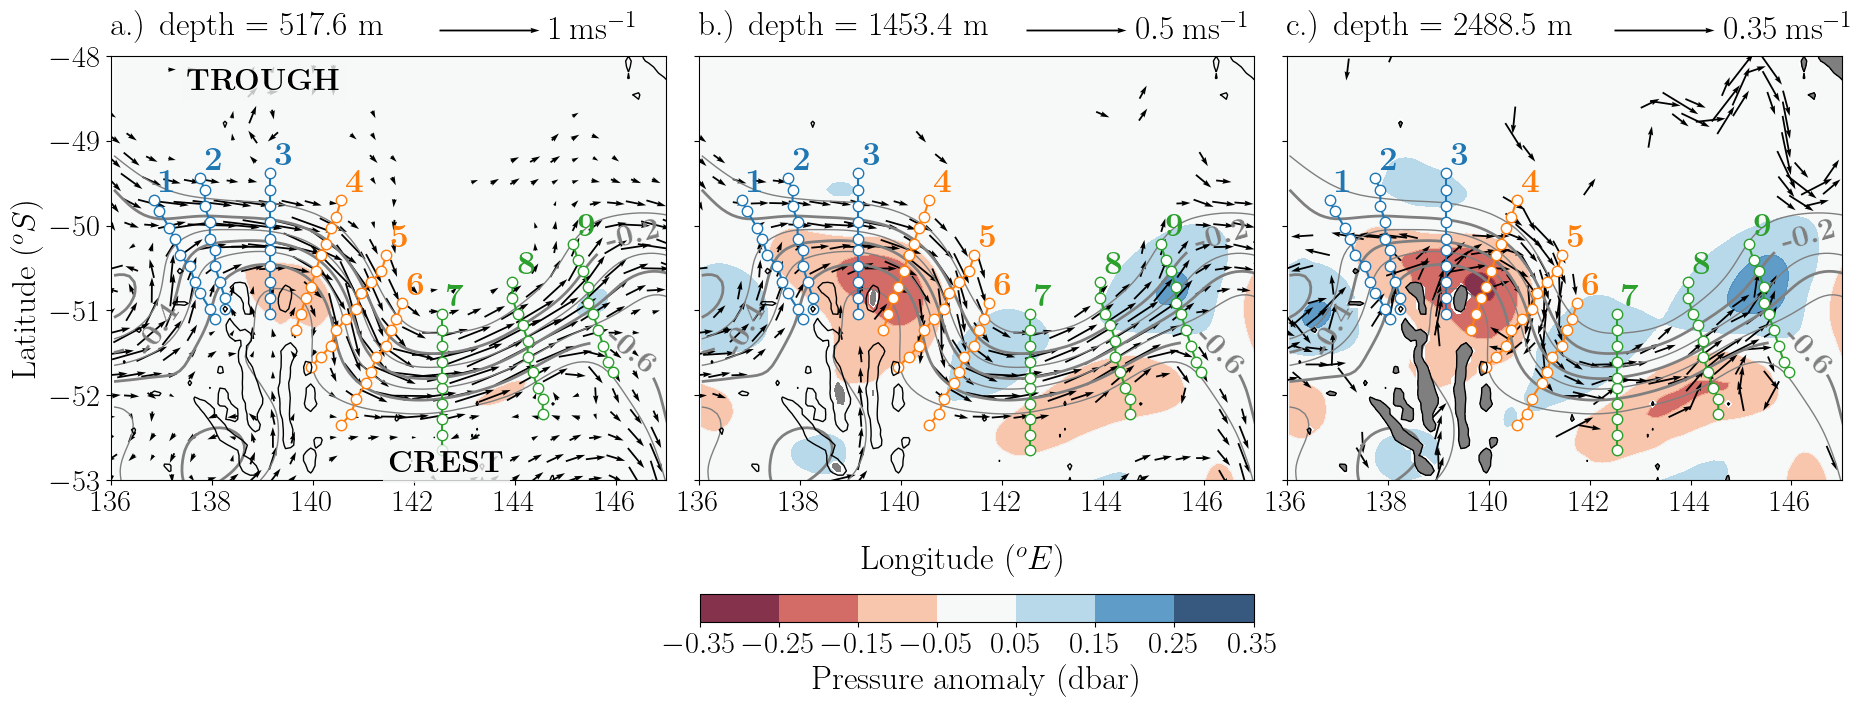

In [33]:
sl_contours = np.linspace(-0.3, 0.3, 7) + core_contour

fig, ax = plt.subplots(figsize=(18,7), ncols=3, sharey=True, constrained_layout=True)

dep = {500: [1, 0.26], 1500: [0.5, 0.58], 2500: [0.35, 0.88]}
for iax, d in enumerate(dep.keys()):

    slc = slice(None, None, 3) if d == 2500 else slice(None, None, 4)
    
    # presssure anomalies at different depths
    pcol = p_anom_flex_mean.sel(st_ocean=d, method='nearest').plot.contourf(
        ax=ax[iax], cmap=cmap, levels=bounds, add_colorbar=False, alpha=0.8)

    # sea level contours
    cont = hydro.sea_level.sel(time=flex_period).mean('time').plot.contour(
        ax=ax[iax], levels=sl_contours, linestyles='solid', linewidths=1, colors='tab:gray')
    for ib, b in enumerate(sl_contours):
        if b in sl_contours[1:-1:2]:
            zc = cont.collections[ib]
            plt.setp(zc, linewidth=2)
    ax[iax].clabel(cont, sl_contours[1:-1:2], inline=1, fontsize=fs_small, fmt=r'{\bf %.1f}', manual=[(146.25, -50), (137, -51.25), (146.25, -51.5)])

    # horizontal velocities at 2500dbar
    vel_t = vel.sel(time=flex_period).mean('time').sel(st_ocean=d, method='nearest')
    quiv = vel_t.where(vel_t.V >= V_threshold).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
        ax=ax[iax], x='xu_ocean', y='yu_ocean', u='u', v='v', color='k',
        units='inches', scale=dep[d][0], width=1e-3*fig.get_size_inches()[0], add_guide=False)
    qk = plt.quiverkey(quiv, 0.77, 1.06, dep[d][0], r'$%s\:\mathrm{ms}^{-1}$' %dep[d][0], labelpos='E', color='k',
                   fontproperties={'size': fs_large}, transform=ax[iax].transAxes)
    
    # along and cross-contour sections
    # ax[iax].plot(along_section.xt_ocean, along_section.yt_ocean, '.-', color='k', markersize=15, markerfacecolor='w')
    for its, (name, data) in enumerate(cross_sections.items()):
        ax[iax].plot(data.xt_ocean, data.yt_ocean, '.-', color=cross_coords[name][1], markersize=15, markerfacecolor='w')
        ax[iax].text(data.xt_ocean[-1]+.1, data.yt_ocean[-1]+.1, r'${\bf %s}$' %(its+1), color=cross_coords[name][1], size=fs_large)
    
    # plot topography
    hydro.ht.plot.contourf(ax=ax[iax], levels=[0, d, 5000], colors=['tab:gray', (1, 1, 1, 0)], add_colorbar=False)
    hydro.ht.plot.contour(ax=ax[iax], levels=[2500], colors='k', linewidths=1)

    # labelling
    if iax == 0:
        ax[iax].text(137.5, -48.4, r'$\mathrm{\bf TROUGH}$', color='k', bbox=dict(facecolor=cmap(128), alpha=0.8, linewidth=0))
        ax[iax].text(141.5, -52.9, r'$\mathrm{\bf CREST}$', color='k', bbox=dict(facecolor=cmap(128), alpha=0.8, linewidth=0))

    ax[iax].text(0, 1.05, string.ascii_lowercase[iax] + '.) depth = %s m' %np.round(p_anom_flex_mean.sel(st_ocean=d, method='nearest').st_ocean.values,1),
                 transform=ax[iax].transAxes, size=fs_large)

    ax[iax].set_xlim([136, 147])
    ax[iax].set_ylim([-53, -48])
    ax[iax].set_ylabel('')
    ax[iax].set_xlabel('')

fig.text(0.51, 0.19, r'Longitude ($^oE$)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.59, r'Latitude ($^oS$)', va='center', rotation='vertical', fontsize=fs_large)

cbar = fig.colorbar(pcol, ax=ax, shrink=0.32, pad=0.15, orientation='horizontal')
cbar.ax.set_xlabel('Pressure anomaly (dbar)', fontsize=fs_large)

In [34]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '02_pressure-anomalies-flexed' + extension), 
                    transparent=transparent, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(136.00000000000358,
 147.50000000000293,
 -53.520843818326696,
 -47.48979973786345)

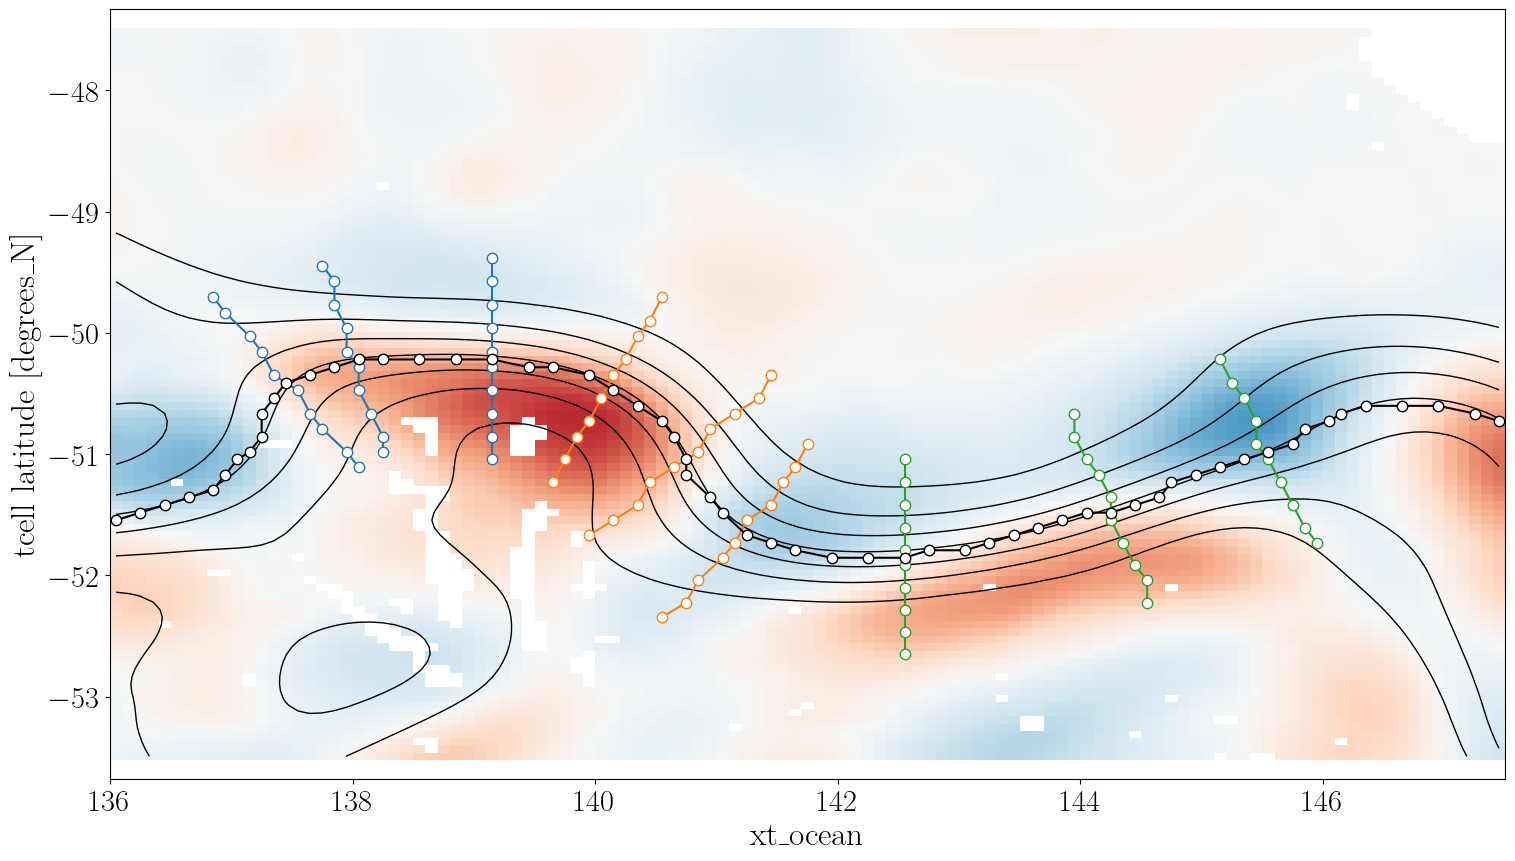

In [35]:
d=2500
fig,ax=plt.subplots(figsize=(18,10))

# presssure anomalies at different depths
pcol = p_anom_flex_mean.sel(st_ocean=d, method='nearest').plot(
    ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

# sea level contours
cont = hydro.sea_level.sel(time=flex_period).mean('time').plot.contour(
    ax=ax, levels=sl_contours, linestyles='solid', linewidths=1, colors='k')

for its, (name, data) in enumerate(cross_sections.items()):
    ax.plot(data.xt_ocean, data.yt_ocean, '.-', color=cross_coords[name][1], markersize=15, markerfacecolor='w')
for its, (name, data) in enumerate(along_section.items()):
    ax.plot(data.xt_ocean, data.yt_ocean, '.-', color='k', markersize=15, markerfacecolor='w')
    

ax.axis('equal')
